## Machine Learning - final project

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
import time, sys
import sklearn.metrics as skmet
from pandas import *

# update_progress() : Displays or updates a console progress bar
## Accepts a float between 0 and 1. Any int will be converted to a float.
## A value under 0 represents a 'halt'.
## A value at 1 or bigger represents 100%
def update_progress(progress):
    barLength = 10 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()


## Gaussian naive-Bayes classifier

In this project you will implement a new classification algorithm, known as the Gaussian naive-Bayes classifier.

In the basis of the naive-Bayes algorithm, it is assumed that the **features** of the data are independent, given the class labels. In particular, in the **Gaussian** naive-Bayes case, the features are assumed to follow a Gaussian distribution:

$$ p(\vec{x_{}}|y=c)=\mathcal{N}(x\ |\ \mu_c,\Sigma_c) $$

and since the features in each class are independent (the model's assumption) then each covariance matrix $\Sigma_c$ takes a **diagonal** form:

$$
\mu_c=
\begin{pmatrix}
\mu_{c,1}\\
\mu_{c,2}\\
\vdots\\
\mu_{c,d}\\
\end{pmatrix}
\ \ \ \ \ \ 
\Sigma_c=
\begin{pmatrix}
\sigma^2_{c,1}\\
 & \sigma^2_{c,2}\\
 &  & \ddots\\
 &  &  & \sigma^2_{c,d}
\end{pmatrix}
\ \ \ \ \ 
c=1,..,k
$$

where $\mu_{c,j}$ is the mean of feature $j$ in class $c$, and
$\sigma^2_{c,j}$ is the variance of feature $j$ in class $c$.

Given a labeled training dataset of $n$ examples: $\{(\vec{x_i},y_i)\}_{i=1}^n$ the algorithm estimates the model parameters $\mu_c$ and $\Sigma_c$ for each and every $c\in\{1,2,...,k\}$. 
(note: This is very similar to the M-step in GMM or k-means algorithms, as the classes assignments are known.)

Then, given a new (unlabelled) example $x$, the classifier prediction is given by:

$$ \hat{y_{}}(x)=\arg \max_c \mathcal{N}(x\ |\ \mu_c,\Sigma_c)\ \ \in\{1,...,k\} $$

Finally, to evaluate the algorithm performance, we will calculate the **accuracy** score, which is the fraction of examples that were labelled correctly by the algorithm (so accuracy of 1 is the best, and 0 is the worst).

Implement the following functions:

1. ```GNB_fit``` function that takes the labeled training dataset (```X``` and ```y```), and returns the GNB parameters:
$\{(\mu_c,\Sigma_c)\}_{c=1}^k$

2. ```GNB_predict``` function that given the GNB parameters and a set of unlabelled examples $X_{test}$ returns a prediction vector ```y_hat``` (with one prediction for each of the examples).

3. ```GNB_score``` function that given the predictions ```y_hat``` and the true labels ```y``` calculates the accuracy score.

Add comments to make your code easy to follow and debug.

Bonus: Try to avoid looping over *examples* or *features* in your code.


In [2]:
# your code here.. 
def PreprocessData(X):
    mu = X.mean(axis=0)
    std = X.std(axis=0)
    return (X - mu)/std
def GNB_fit(X,Y):
    j = 0
    C = np.amax(Y)
    mus = []
    sigmas = []
    #assume Yj belongs to C = {0,1,...,K}
    while(j <= C):
        tag = np.where(Y == j)
        #find matching samples to C by Yj
        matches = X[tag,:]
        #calculate mu_c
        python_mean = matches.mean(axis=1).ravel()
      
        #calculate cov
        python_cov = (np.var(matches,axis=1).ravel())
       
        mus += [python_mean]
        #calculate sigma_C
        sigmas +=[python_cov]
        j = j + 1
    return mus,sigmas
def GNB_predict(mus,sigmas,X_test,allowSingular = False):
    i = 0
    n = X_test.shape[0]
    C = len(mus)
    y_hat = np.zeros(n)
    probabilityMatrix = []
    j = 0
    #Buld the probabilityMatrix which size is CXn and each cell(i,j) holds the probability for the i-th class of the j-th sample 
    while(j < C):
        probRow = multivariate_normal.pdf(X_test,mean=mus[j], cov=sigmas[j],allow_singular = allowSingular)
        probabilityMatrix += [probRow]
        j = j + 1
    #select the class of the j-th sample with highest probability
    y_hat = np.argmax(probabilityMatrix, axis=0)
    return y_hat
def GNB_score(y_hat,y):
    matches_count = len(np.where(y_hat==y)[0])
    total_count = len(y_hat)
    accuracy_score = matches_count/total_count
    return accuracy_score
    

### Test case I: The breast cancer dataset 

The Wisconsin breast cancer dataset consists of $n=569$ samples, each consists of 30 features describing physical properties of the tumor. Each sample is binary labelled as 'malignant' (y=0) or 'benign' (y=1). 


(569, 30)


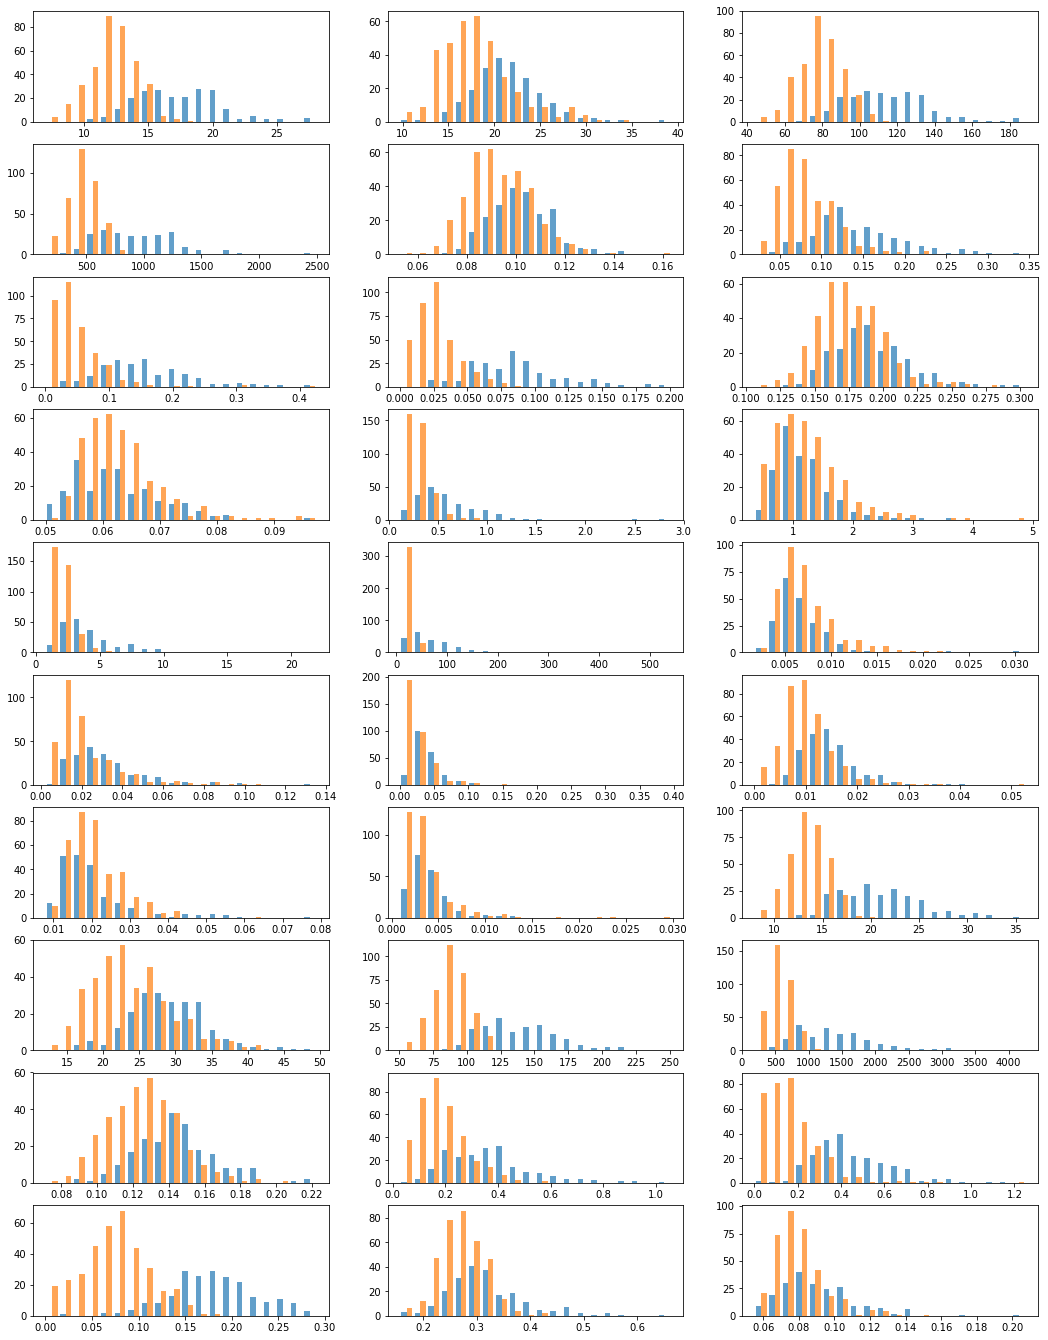

In [3]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

y = data.target
X = data.data


print(X.shape)
n,d = X.shape


plt.figure(figsize=(18,24))
for i in range(d):
    plt.subplot(10,3,i+1)
    plt.hist([X[y==0,i],X[y==1,i]],20,alpha=0.7);


- Fit a Gaussian naive-Bayes model to 70% of the data, and test the model on the rest (30%) of it. 

(You should get an accuracy of more than 90%...)

In [4]:
# your code here..
last_in_train = int(n*0.7)
training_data = X[range(0,last_in_train)]
training_labels = y[range(0,last_in_train)]

tst_data  = X[range(last_in_train,n)]
tst_labels = y[range(last_in_train,n)]
mus,sigmas = GNB_fit(training_data,training_labels)
y_hat = GNB_predict(mus,sigmas,tst_data,True)
a_score = GNB_score(y_hat,tst_labels)
print("the score of the model fitted in percentage is: ",a_score * 100)

the score of the model fitted in percentage is:  95.32163742690058


### Test case II: The Olivetti faces dataset 

This dataset consists of 400 faces images (64x64 pixels each) of 40 different people (10 images of each person). 

Note, that the number of features here (d=64x64=4096) is much higher than the number of examples (n=400). In order to avoid significant overfitting of the model, we will try to reduce the number of features (using PCA) before we fit the classifier. 




[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
(400, 4096)


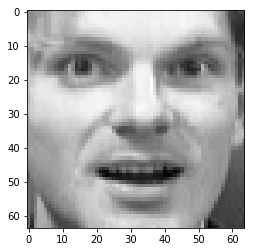

In [5]:
from scipy.io import loadmat

data = loadmat('faces.mat')

y = data['target']
X = data['data']



print(np.unique(y))

print(X.shape)
n,d = X.shape

plt.imshow(X[2,:].reshape(64,64),interpolation='nearest',cmap='gray')
plt.show()



#### Part A: PCA

Implement a PCA function that for a given dataset matrix ```X``` (of size $n\times d$) returns a matrix ```U``` containing all the principal vectors in a descending order. 

Note: the function should check whether $n>d$ or $n<d$, and proceed accordingly,

in case that $n>d$:
$$ \begin{align}
X&=X-\bar{X_{}}\\
C&=X^T X \ \ \ (d\times d)\\ 
Cu&=\lambda u
\end{align} $$


in case that $n<d$:
$$ \begin{align}
X&=X-\bar{X_{}}\\
\tilde{C_{}}&=XX^T \ \ \ (n\times n)\\
\tilde{C_{}}v&=\lambda v \\
u&=X^T v \\
u&=\frac{u}{\Vert u \Vert}
\end{align} $$

- Plot the first 6 principal vectors of the faces data (a.k.a 'eigen-faces') 



(4096, 400)
the eigen-faces


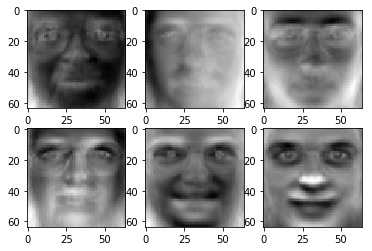

In [6]:
# your code here.. 
def PCA(X): 
    n = X.shape[0]
    d= X.shape[1]
    mu = np.mean(X,axis=0)
    zero_mean_X = X - mu
    if(n>=d):    
        C = zero_mean_X.T.dot(zero_mean_X)/zero_mean_X.shape[0]
        evls,U = np.linalg.eig(C)
    else:
        C = zero_mean_X.dot(zero_mean_X.T)/n 
        evls,v = np.linalg.eig(C)
        U = zero_mean_X.T.dot(v)
        U = U/np.linalg.norm(U)
    return U[:,(-evls).argsort()]
U = PCA(X)
print(U.shape)
eigenvectors = U.T
print("the eigen-faces")
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(eigenvectors[i,:].reshape(64,64),interpolation='nearest',cmap='gray')
plt.show()

#### Part B: Classification

Fit a Gaussian naive-Bayes model to the data, after reducing it to $K=1,2,...,200$ dimensions using PCA.

- Use 5-fold cross-validation to estimate the accuracy score on the training-set and on the validation-set, for each value of $K$. Plot both score curves as a function of $K$. 

- Choose the best value for $K$, and run the algorithm on 70% of the data. Use the rest of the data for validation, and plot a $40\times 40$ confusion matrix (see Ex.4).

Optimizing dimension for leaning, K=1,2...,200 dimensions using 5-fold cross-validation
Percent: [##########] 100% Done...99999%  


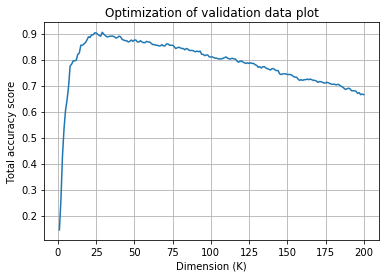

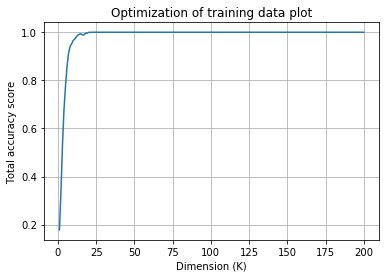

the optimal dimension for learning is 29
the score of the model fitted in percentage is:  86.66666666666667
confustion matrix for test data


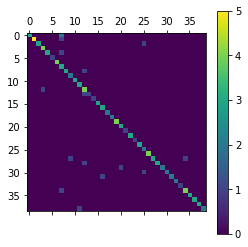

Displaying test faces by sorted y_hat


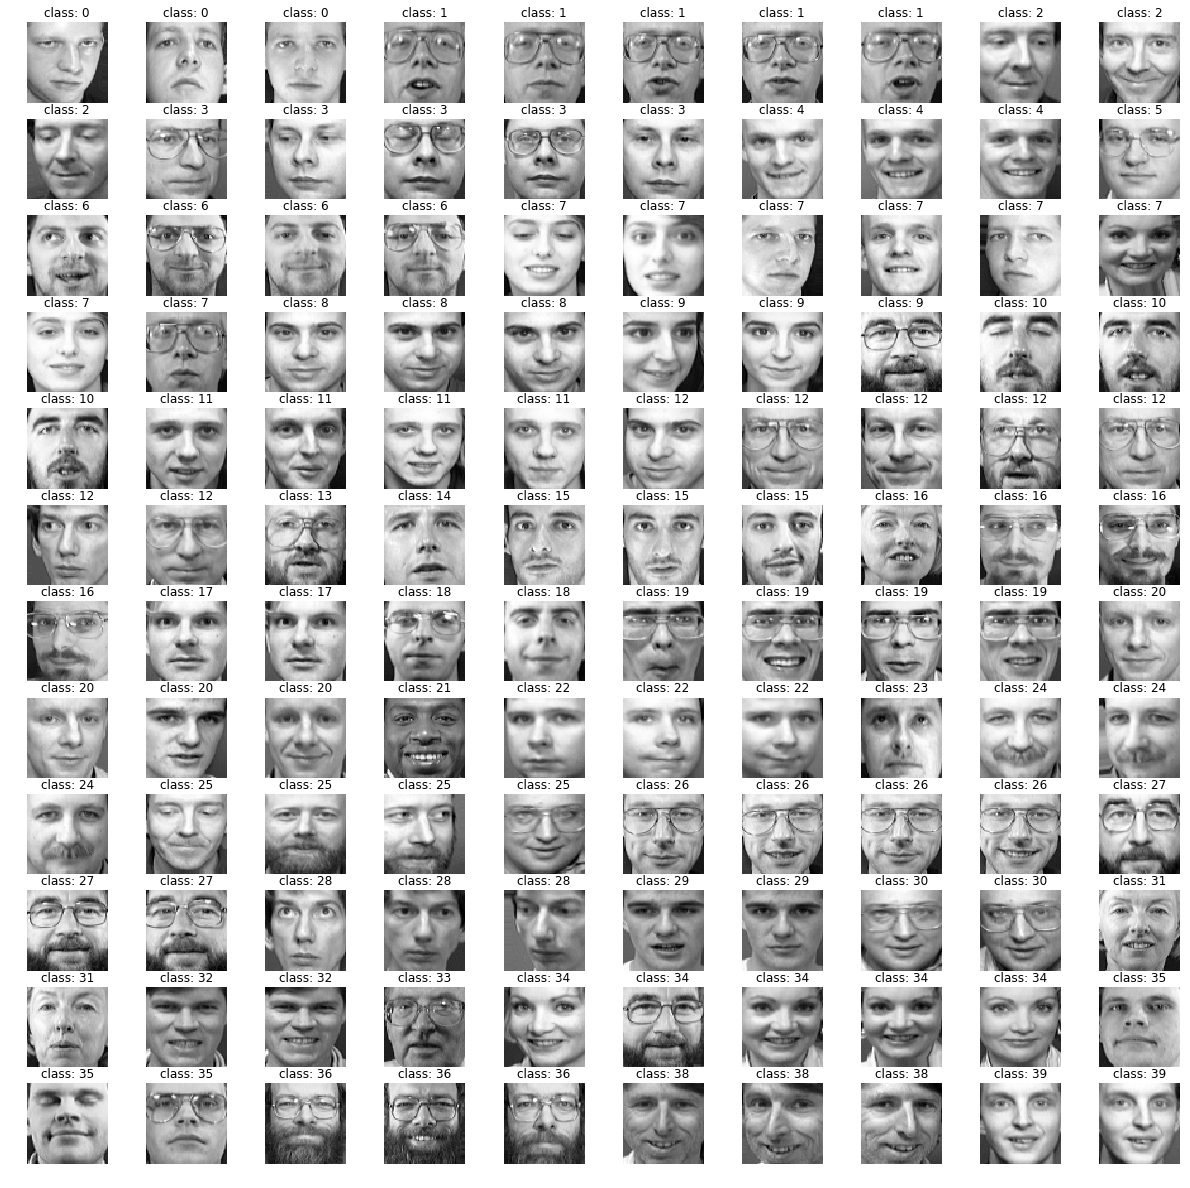

In [7]:
# your code here.. 
X = PreprocessData(X)
def optimizeLearningDimenssion(max_k=200,fold_k=5):
    print("Optimizing dimension for leaning, K=1,2...,{} dimensions using {}-fold cross-validation".format(max_k,fold_k))
    k = 1
    U = PCA(X)
    scores_for_train_k = []
    scores_for_test_k = [] 
    #prepare labels for fold_k-fold cross validation
    bin_size = int(n/fold_k) 
    cross_validation_bins_labels = []
    bin_current = 0
    bin_next = bin_size
    while(bin_current < n):
        cross_validation_bins_labels += [y[range(bin_current,bin_next)]]
        bin_current = bin_next
        bin_next = bin_next + bin_size
    cross_validation_bins_labels = np.array(cross_validation_bins_labels)
    cross_validation_bins_indicies = np.arange(fold_k)
    #prepare unchanging data for fold_k cross validation
    
    #start dimensional check by using PCA to reduct to k = 1,2,....,200
    while(k <= max_k):
        take_U = U[:,range(k)]
        Z = X.dot(take_U)
        cross_validation_bins = []
        bin_current = 0
        bin_next = bin_size
        while(bin_current < n):
            cross_validation_bins += [Z[range(bin_current,bin_next)]]
            bin_current = bin_next
            bin_next = bin_next + bin_size
        cross_validation_bins = np.array(cross_validation_bins) 
        i = 0
        scores_test = []
        scores_train = []
        while(i < fold_k):
            Z_tst = cross_validation_bins[i]
            Z_tst_labels = cross_validation_bins_labels[i]
            Z_tst_labels = Z_tst_labels.reshape(Z_tst_labels.shape[0])
    
            Z_train = cross_validation_bins[cross_validation_bins_indicies !=i]
            Z_train = Z_train.reshape(Z_train.shape[0] * Z_train.shape[1],Z_train.shape[2])

            Z_train_labels = cross_validation_bins_labels[cross_validation_bins_indicies !=i]
            Z_train_labels = Z_train_labels.reshape(Z_train_labels.shape[0] * Z_train_labels.shape[1])
 
            mus,sigmas = GNB_fit(Z_train,Z_train_labels)
            y_hat = GNB_predict(mus,sigmas,Z_tst)
            a_score = GNB_score(y_hat,Z_tst_labels)
            scores_test += [a_score]
        
            y_hat = GNB_predict(mus,sigmas,Z_train)
            a_train_score = GNB_score(y_hat,Z_train_labels)
            scores_train += [a_train_score]
            i = i + 1
        scores_for_test_k += [np.mean(scores_test)]
        scores_for_train_k += [np.mean(scores_train)]
        update_progress(k/max_k)
    
        k = k + 1
    plt.title("Optimization of validation data plot")
    plt.xlabel('Dimension (K)')
    plt.ylabel('Total accuracy score')
    plt.plot(range(1,max_k+1),scores_for_test_k)
    plt.grid()
    plt.show()

    plt.title("Optimization of training data plot")
    plt.xlabel('Dimension (K)')
    plt.ylabel('Total accuracy score')
    plt.plot(range(1,max_k+1),scores_for_train_k)
    plt.grid()
    plt.show()

    optimal_k = np.argmax(scores_for_test_k) + 1
    print("the optimal dimension for learning is {}".format(optimal_k))
    return optimal_k
optimal_k =optimizeLearningDimenssion()
U = PCA(X)[:,range(optimal_k)]
Z = X.dot(U)
n = Z.shape[0]
last_in_train = int(n*0.7)
training_data = Z[range(0,last_in_train)]
training_labels = y[range(0,last_in_train)]
training_labels = training_labels.reshape(training_labels.shape[0])

tst_data  = Z[range(last_in_train,n)]
tst_labels = y[range(last_in_train,n)]
tst_labels = tst_labels.reshape(tst_labels.shape[0])

mus,sigmas = GNB_fit(training_data,training_labels)
y_hat = GNB_predict(mus,sigmas,tst_data)
a_score = GNB_score(y_hat,tst_labels)
print("the score of the model fitted in percentage is: ",a_score * 100)
test_confustion_matrix = skmet.confusion_matrix(tst_labels, y_hat, sample_weight=None)
print("confustion matrix for test data")
plt.matshow(test_confustion_matrix)
plt.colorbar()
plt.show()

print("Displaying test faces by sorted y_hat")
sortby = np.argsort(y_hat)
sorted_y_hat = y_hat[sortby]
X = data['data']
tst_data  = X[range(last_in_train,n)]
tst_data =  tst_data[sortby]
plt.figure(figsize=(21,21))
for i in range(tst_data.shape[0]):
    plt.subplot(tst_data.shape[0]/10,10,i+1)
    plt.imshow(tst_data[i,:].reshape(64,64),interpolation='nearest',cmap='gray')
    plt.title("class: {}".format(sorted_y_hat[i]))
    plt.axis('off')
plt.show()

## Good luck !